In [532]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.tabular import *
from IPython.display import FileLink, FileLinks
torch.cuda.is_available()

True

In [643]:
path = Path('./data')
LABELS = 'labels.csv'
TRAIN = 'train.csv'
TEST = 'test.csv'
SAMPLE = 'gender_submission.csv'
batch_size = 16

In [644]:
df = pd.read_csv(path/TRAIN)
origTestDf = pd.read_csv(path/TEST)
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [645]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [646]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [649]:
def prepareDf(df):
    df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    df['Age'] = df.Age.fillna(df.Age.mean()).astype(np.int32)
    df['Fare'] = df.Fare.fillna(df.Fare.mean()).astype(np.int32)
    df['Embarked'] = df.Embarked.fillna('S')
    return df

df = prepareDf(df)
testDf = prepareDf(origTestDf)
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22,1,0,7,S
1,1,1,female,38,1,0,71,C
2,1,3,female,26,0,0,7,S
3,1,1,female,35,1,0,53,S
4,0,3,male,35,0,0,8,S
5,0,3,male,29,0,0,8,Q
6,0,1,male,54,0,0,51,S
7,0,3,male,2,3,1,21,S
8,1,3,female,27,0,2,11,S
9,1,2,female,14,1,0,30,C


In [650]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [651]:
df[df.Embarked.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [652]:
procs = [FillMissing, Categorify, Normalize]

In [653]:
valid_idx = random.sample(list(df.index), int(0.2 * len(df)))
len(valid_idx)

178

In [654]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Fare']

In [655]:
cards = df[cat_names].apply(pd.Series.nunique); cards

Pclass       3
Sex          2
Age         71
SibSp        7
Parch        7
Embarked     3
Fare        91
dtype: int64

In [656]:
szs = pd.np.minimum(50, (cards+1)//2); szs

Pclass       2
Sex          1
Age         36
SibSp        4
Parch        4
Embarked     2
Fare        46
dtype: int64

In [666]:
# emb_szs = dict((name, szs[name]) for name in cat_names); emb_szs
emb_szs = dict((name, 50) for name in cat_names); emb_szs

{'Pclass': 50,
 'Sex': 50,
 'Age': 50,
 'SibSp': 50,
 'Parch': 50,
 'Embarked': 50,
 'Fare': 50}

In [667]:
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names, test_df=testDf)

In [668]:
print(data.train_ds.cat_names)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Fare']


In [740]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, emb_szs=emb_szs, ps=[0.5, 0.8], emb_drop=0.5, use_bn=True)
# learn.opt_func = partial(optim.Adam, betas=(0.7, 0.9))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


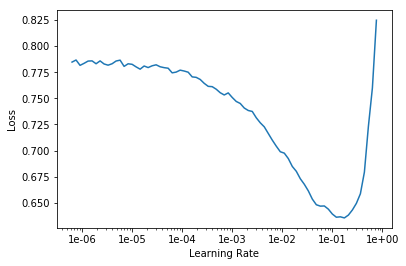

In [741]:
learn.lr_find()
learn.recorder.plot()

In [742]:
lr = 1e-2

In [743]:
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,accuracy
1,0.670979,0.696657,0.404494
2,0.608060,0.682759,0.803371
3,0.570488,0.632205,0.623595
4,0.541717,0.556569,0.735955
5,0.509831,0.504331,0.769663
6,0.487479,0.522106,0.792135
7,0.470335,0.525531,0.808989
8,0.449400,0.600231,0.780899
9,0.433803,0.563480,0.803371
10,0.417079,0.521707,0.814607


In [732]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy
1,0.128623,0.981985,0.814607


In [678]:
int(learn.predict(testDf.iloc[0])[0])

0

In [693]:
len(testDf)

418

In [744]:
preds, targets = learn.get_preds(DatasetType.Test); preds[:5]

tensor([[0.9471, 0.0529],
        [0.8967, 0.1033],
        [0.9918, 0.0082],
        [0.7377, 0.2623],
        [0.1045, 0.8955]])

In [745]:
len(preds)

418

In [746]:
res = np.argmax(preds, axis=1); res[:10]

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [747]:
gender = pd.read_csv(path/SAMPLE);
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [748]:
out = origTestDf.assign(Survived=res)[['PassengerId', 'Survived']]; out.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [749]:
subPath = path/'sub5.csv'
out.to_csv(subPath, index=False)
FileLink(subPath)

/home/jupyter/alonso/titanic/data/sub5.csv